In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
root_dir = os.path.dirname(os.path.abspath(''))
if not root_dir in sys.path: sys.path.append(root_dir)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
import scipy.io as sio

%matplotlib nbagg

In [3]:
from scipy.special import binom as binom_fun
from scipy.special import factorial as sp_factorial
from scipy.integrate import quad

import theano
import theano.tensor as T
from theano.graph.op import Op
from theano.graph.basic import Apply
from theano.compile.io import In

import pymc3 as pm
import arviz as az

In [4]:
from inference import *
from DM_theory import *
from empirical.readData import *
from empirical.model import *

In [5]:
theano.config.optimizer = 'fast_run'
theano.config.exception_verbosity = 'high'
theano.config.on_unused_input = 'warn'
theano.config.mode = 'FAST_RUN'

In [6]:
class integrateOut(Op):
    """
    Integrate out a variable from an expression, computing
    the definite integral w.r.t. the variable specified
    
    !!! vectorized implementation still somewhat buggy in the gradient !!!
    
    function adapted from https://stackoverflow.com/questions/42678490/custom-theano-op-to-do-numerical-integration
    """
    
    def __init__(self,f,t,vectorize,*args,**kwargs):
        super(integrateOut,self).__init__()
        self.f = f
        self.t = t
        self.vectorize = vectorize

    def make_node(self,*inputs):
        self.fvars=list(inputs)
        # This will fail when taking the gradient... don't be concerned
        try:
            self.gradF = T.jacobian(self.f,self.fvars)
        except:
            self.gradF = None
            
        if self.vectorize:
            return Apply(self,self.fvars,[T.dvector().type()])
        else:
            return Apply(self,self.fvars,[T.dscalar().type()])

    def perform(self,node, inputs, output_storage):
        nu_max = inputs[3]
        
        ## integrate the function from 0 to maximum firing rate nu_max
        if self.vectorize:
            f = theano.function([self.t]+self.fvars,self.f)
            
            N_AP = inputs[0]
            output = np.zeros_like(N_AP,dtype='float64')
            for i,N in enumerate(N_AP):
                args = inputs[:]
                args[0] = np.array([N])   # necessary to be 1-dim vector to satisfy function-blueprint
                #print(f'args: {args}')
                output[i] = quad(f,0,nu_max,args=tuple(args))[0]
            output_storage[0][0] = output
        else:
            f = theano.function([self.t]+self.fvars,self.f)
            output_storage[0][0] = np.array(quad(f,0,nu_max,args=tuple(inputs))[0],dtype='float64')

    def grad(self,inputs,output_grads):
        nu_max = inputs[3]
        
        # need to map variable names of function to input variables, 
        # as they might not agree (scan creates differently named copies)
        giv = {}
        for v,v_new in zip(self.fvars[1:],list(inputs)[1:]):
            giv[v] = v_new
        
        if self.vectorize:
            return [T.mean(integrateOut(theano.clone(g,replace=giv),self.t,self.vectorize)(*inputs))*output_grads[0] \
                for g in self.gradF]
        else:
            return [integrateOut(theano.clone(g,replace=giv),self.t,self.vectorize)(*inputs)*output_grads[0] \
                for g in self.gradF]

In [7]:
class theano_binomial(Op):
    
    __props__ = ()
    itypes = [T.lscalar,T.lvector]
    otypes = [T.lvector]

    def perform(self,node,inputs,output_storage):
        # actually compute the binomial
        n,k = inputs
        output_storage[0][0] = np.array(binom_fun(n,k),dtype='int64')

In [8]:
#from DM_theory import *
def p_nu(NU,gamma,delta,nu_max):
    return gamma / ( nu_max * T.sqrt( -np.pi * T.log( NU / nu_max ) ) ) * \
        T.exp( - delta**2/2.) * ( NU / nu_max )**(gamma**2 - 1) * \
        T.cosh( gamma * delta * T.sqrt( -2 * T.log( NU / nu_max) ) )

def poisson_spikes(nu,N,T_total):
    return (nu*T_total)**N / T.gamma(N+1) * T.exp(-nu*T_total)

In [8]:
#from empirical import *

class Inference:

    dataLoaded = False
    paras = {}

    def __init__(self):

        os.environ['MKL_NUM_THREADS'] = '1'
        os.environ['OPENBLAS_NUM_THREADS'] = '1'

    def set_model(self, func, paras=None):
        assert self.dataLoaded, "Data is not yet loaded, but required for setting the model parameters! (using 'load_data')"

        if callable(func):
            logp = func
        elif func=='selfcon':

            if not paras:
                paras = {
                    'gamma':{'mu':1.5, 'sigma':1.0, 'sigma_animal':1.0,'prior':'Normal'},
                    'delta':{'mu':4.,'sigma':2., 'sigma_animal':1.0,'prior':'Normal'},
                    'nu_max':{'mu':60.,'sigma':20., 'sigma_animal':5.0,'prior':'Normal'}
                }
            assert all(key in paras for key in ("gamma","delta","nu_max")), "Please provide all necessary parameters!"
            def logp(data,gamma,delta,nu_max):
                
                print('define logp from counts')
                N = mP.rates['WT']['20180310A']
                N = (N[~np.isnan(N)]*60).astype('int64')

                n = len(N)
                N_ = Counter(N).keys()
                k_with_N = Counter(N).values()

                N_AP = data['N_AP']
                k_with_N_AP = data['k_with_N_AP']
                n = data['n']
                
                p_N_AP_arr, updates = theano.scan(
                    fn = lambda N, gamma, delta, nu_max : integrateOut(p_nu(nu,gamma,delta,nu_max)*poisson_spikes(nu,N,T_total),nu,vectorize=False)(N,gamma,delta,nu_max), 
                    sequences=[N_AP],
                    non_sequences=[gamma,delta,nu_max],
                )
                p_k = theano_binomial()(n,k_with_N_AP) * p_N_AP_arr**k_with_N_AP * (1-p_N_AP_arr)**(n - k_with_N_AP)
                
                return T.log(p_k)
                
                #if type(data)==np.array:
                #    
                #    data_silent = data==0
                #    N_silent = data_silent.sum()
                #    data = data[data_silent]

                #    p_silent = integrate.quad(lambda nu : p_nu(nu,gamma,delta,nu_max)*np.exp(-nu*T),0,10)

                #scaled_NU = tt.log(data / nu_max)
                #return - tt.log( nu_max / gamma * tt.sqrt( -np.pi * scaled_NU ) ) - delta**2 / 2 + \
                #    ( gamma**2 - 1 ) * scaled_NU + \
                #    tt.log( tt.cosh( gamma * delta * tt.sqrt( -2 * scaled_NU ) ) )

            # def logp_raw(data,paras):
            #     scaled_NU = np.log(data / nu_max)
            #     return - np.log( nu_max / gamma * np.sqrt( -np.pi * scaled_NU ) ) - delta**2 / 2 + \
            #         ( gamma**2 - 1 ) * scaled_NU + \
            #         np.log( np.cosh( gamma * delta * np.sqrt( -2 * scaled_NU ) ) )

        elif func=='lognorm':
            assert all(key in paras for key in ("mu","sigma")), "Please provide all necessary parameters!"

            def logp(data,paras):
                return 0


        self.logp = logp
        # self.logp_raw = logp_raw

        for key in paras.keys():
            self.paras[key] = {}
            for para in paras[key].keys():
                self.paras[key][para] = paras[key][para]


    def load_data(self, dataType='empirical', filePath='../data/BuscheLab/2P_data.xlsx',include_silent=False):

        self.mP = ModelParams(dataType, filePath=filePath, population_keys=['*mouse_type','animal'])
        self.data_df = self.mP.regularize_rates()

        self.data = self.data_df.to_numpy()

        N_zeros = (self.data==0).sum()
        print(f'zeros in data: {N_zeros}')
#        self.data[self.data==0] = np.random.rand(N_zeros)*1./600
        if include_silent:
            T = 600.
            self.data[self.data<=1./T] = -np.log(1-np.random.rand((self.data<=1./T).sum()))/T

        self.data_mask = ~np.isnan(self.data) & (self.data>0)

        self.dataLoaded = True


    def construct_model_hierarchical(self, name):

        """
            function to create a hierarchical model of the parameter 'name'.

            Input:
                name: string
                    name of the parameter, used for distribution name
                mP: ModelParams Object
                    including 'rates' DataFrame, arranged in a multicolumnar structure
                    reflecting the different populations. Column names starting with '*'
                    are used on the hierarchical level to infer mean value lower level
                    distributions
                mu_population: float
                    mean value of top-level prior
                sigma_population: float
                    std of top-level prior
                sigma_animal:
                    std of low-level prior

            Output:
                prior_animal: pm.distribution
                    distribution containing a draw for each neuron in the dataset
                    ! this should be masked, when populations contain different neuron
                    numbers

            ToDo:
                * enable using different distributions, other than 'Normal' (default)
                * in both, top and bottom level?
                * what about Student-T?
        """

        # obtain information from data-column-header
        population_names = list(self.mP.rates.columns.names)
        N_levels = len(population_names)

        # only columns with '*' are used for top-level inference
        is_hierarchical = [name.startswith('*') for name in population_names]

        print(f'name: {name}')
        print(self.paras[name])

        hierarchical_shape = [
            sha if is_hierarchical[p] else 1
            for p,sha in enumerate(self.mP.data_shape)
        ]
        # print(hierarchical_shape)

        # create top-level distribution for prior mean-values
        prior_mean = self.paras[name]['mu'] + \
            pm.Normal(f'{name}_population',
                mu=0.,
                sigma=self.paras[name]['sigma'],
                shape=hierarchical_shape
            )
        # tt.printing.Print('prior mean shape')(tt.shape(prior_mean))

        # create real distribution, from which values are drawn
        prior_animal = pm.Normal(f'{name}',
            mu=prior_mean,
            sigma=self.paras[name]['sigma_animal'],
            shape=self.mP.data_shape
        )

        # tt.printing.Print('prior animal')(tt.shape(prior_animal))
        prior_animal = prior_animal.reshape((1,-1))

        # tt.printing.Print('prior animal')(tt.shape(prior_animal))

        # broadcast distribution to draw values for each neuron
        prior_animal = tt.tile(
            prior_animal,
            (self.data.shape[0], 1) ### why -1?    *[1]*(N_levels-1)
        )
        tt.printing.Print('prior animal (final)')(tt.shape(prior_animal))

        return prior_animal


    ## currently issues: ~99% of traces diverge -> pole is difficult to fit
    def run_on_data(self,draws=5000,tune=10000,loadPath=None,savePath=None,**kwargs):

        """
            ToDo:
                * adjust logp method, such that it calculates
                    \int_0^1/T logp(nu) dnu
                to estimate probability of 0Hz measurements, instead of point-measure at 1/T
                -> use scipy.integrate.quad
                * write documentation!
        """

        if loadPath:
            self.trace = az.from_netcdf(loadPath)
            return

        data_observed = self.data[self.data_mask]
        print(f'data: {self.data}')
        print(f'data observed: {data_observed}')
        
        ## prepare data such that we have all necessary values
        
        
        #silent = tt.le(data_observed,1./600)
        with pm.Model() as model:
            # replace normals with student-t distributions

            priors = {}
            for para in self.paras:
                priors[para] = self.construct_model_hierarchical(para)
                priors[para] = priors[para][self.data_mask]


            def likelihood(data):

                # introduce checks for consistency, etc
                logP = self.logp(data,**priors)

                # penalize nan-entries (e.g. when log is negative, etc)
                # logP_masked = tt.switch(tt.isnan(logP), 0, logP)
                # logP = tt.switch(silent, logP-10., logP)
                #min_val = tt.min(logP_masked)
                #tt.printing.Print('logP minimum')(tt.min(logP_masked))
                tt.printing.Print('logP')(logP)

                #logP = tt.switch(tt.isnan(logP), min_val*2, logP)

                return tt.sum(logP)

            ## watch out: for some reason, NaNs in observed data are converted to 0s
            logP = pm.DensityDist('logP',likelihood,observed=data_observed)

            trace = pm.sample(
                init='adapt_diag',
                step=pm.Metropolis(),
                chains=4,draws=draws,tune=tune,
                return_inferencedata=True,
                **kwargs)

            if savePath:
                trace.to_netcdf(savePath)

            self.trace = trace


In [9]:
mP = ModelParams('empirical',filePath='../../data/BuscheLab/2P_data.xlsx',population_keys=['mouse type','animal'])

In [11]:
### define theano constants and variables
T_total = theano.shared(60.)                     # measurement time

n = T.lscalar('n')                 # number of neurons in data set
k_with_N_AP = T.lvector('k_with_N_AP')   # number of neurons observed with N_AP spikes

N_AP = T.lvector('N_AP')           # number of action potentials (should be vector)
#N = T.dscalar('N')

nu = T.dscalar('nu')

gamma = T.dscalar('gamma')
delta = T.dscalar('delta')
nu_max = T.dscalar('nu_max')

In [10]:
mP.rates

mouse type        WT                                       LM (APLP1 KO)  \
animal     20180310A 20180312A 20180310B 20180401 20180325 (app ko7 739)   
0                0.0       0.0       0.0      0.0                    0.0   
1                0.0       0.0       0.0      0.0                    0.0   
2                0.0       0.0       0.0      0.0                    0.0   
3                0.0       0.0       0.0      0.0                    0.0   
4                0.0       0.0       0.0      0.0                    0.0   
..               ...       ...       ...      ...                    ...   
365              NaN       NaN       NaN      NaN                    NaN   
366              NaN       NaN       NaN      NaN                    NaN   
367              NaN       NaN       NaN      NaN                    NaN   
368              NaN       NaN       NaN      NaN                    NaN   
369              NaN       NaN       NaN      NaN                    NaN   

mouse type                                                   \
animal     20180325A (app ko8 740) 20180402A (app ko13 734)   
0                              0.0                      0.0   
1                              0.0                      0.0   
2                              0.0                      0.0   
3                              0.0                      0.0   
4                              0.0                      0.0   
..                             ...                      ...   
365                            NaN                      NaN   
366                            NaN                      NaN   
367                            NaN                      NaN   
368                            NaN                      NaN   
369                            NaN                      NaN   

mouse type                             cTKO                              \
animal     20180419 (app ko14 756) 20180309 20180310  20180311 20180329   
0                              0.0      0.0      0.0  0.000000      0.0   
1                              0.0      0.0      0.0  0.000000      0.0   
2                              0.0      0.0      0.0  0.000000      0.0   
3                              0.0      0.0      0.0  0.000000      0.0   
4                              0.0      0.0      0.0  0.000000      0.0   
..                             ...      ...      ...       ...      ...   
365                            NaN      NaN      NaN  6.153846      NaN   
366                            NaN      NaN      NaN  6.153846      NaN   
367                            NaN      NaN      NaN  6.923077      NaN   
368                            NaN      NaN      NaN  7.307692      NaN   
369                            NaN      NaN      NaN  8.076923      NaN   

mouse type            
animal     20180329A  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
..               ...  
365              NaN  
366              NaN  
367              NaN  
368              NaN  
369              NaN  

[370 rows x 13 columns]

In [11]:
mP.rates['WT'].columns.get_level_values('animal')

Index(['20180310A', '20180312A', '20180310B', '20180401'], dtype='object', name='animal')

In [15]:
data = mP.rates
data_obs = []

for mType in np.unique(data.columns.get_level_values('mouse type')):
    
    for animal in data[mType].columns:
        print(f'type: {mType}, {animal}')
        
        N = data[mType][animal]
        N = (N[~np.isnan(N)]*60).astype('int64')

        N_ct = Counter(N)
        
        data_obs.append({
            'n': len(N),
            'N_AP': N_ct.keys(),
            'k_with_N_AP': N_ct.values()
        })

for i in range()
print(data_obs)

type: LM (APLP1 KO), 20180325 (app ko7 739)
type: LM (APLP1 KO), 20180325A (app ko8 740)
type: LM (APLP1 KO), 20180402A (app ko13 734)
type: LM (APLP1 KO), 20180419 (app ko14 756)
type: WT, 20180310A
type: WT, 20180312A
type: WT, 20180310B
type: WT, 20180401
type: cTKO, 20180309
type: cTKO, 20180310
type: cTKO, 20180311
type: cTKO, 20180329
type: cTKO, 20180329A
[{'n': 256, 'N_AP': dict_keys([0, 17, 19, 23, 34, 39, 46, 51, 59, 68, 69, 79, 86, 92, 98, 103, 115, 118, 120, 137, 138, 155, 158, 161, 172, 178, 184, 206, 207, 223, 230, 253, 257, 258, 276, 323, 346, 369, 392, 396, 461, 499, 507, 553, 600, 646, 669, 715, 946]), 'k_with_N_AP': dict_values([71, 7, 4, 26, 9, 2, 17, 14, 3, 8, 10, 1, 5, 8, 3, 4, 6, 1, 1, 4, 4, 1, 1, 6, 1, 1, 5, 2, 2, 2, 4, 3, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1])}, {'n': 277, 'N_AP': dict_keys([0, 17, 19, 21, 23, 27, 34, 39, 42, 46, 59, 63, 69, 79, 83, 85, 92, 98, 106, 115, 127, 138, 158, 161, 166, 178, 191, 193, 207, 221, 230, 234, 253, 255, 300, 362,

<IPython.core.display.Javascript object>


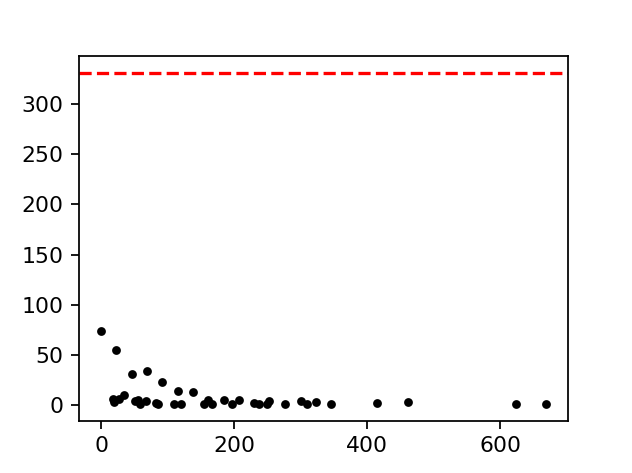

In [12]:
from collections import Counter

N = mP.rates['WT']['20180310A']
N = (N[~np.isnan(N)]*60).astype('int64')

n = len(N)
N_ = Counter(N).keys()
k_with_N = Counter(N).values()

fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(N_,k_with_N,'k.')
ax.axhline(n,color='r',ls='--')
plt.show()

In [12]:
def run_inference(filePath='../../data/BuscheLab/2P_data.xlsx',tune=20000,draws=10000,include_silent=False,
                 loadPath=None,savePath=None):
    I = Inference()
    I.load_data('empirical',filePath=filePath,include_silent=include_silent)
    I.set_model('selfcon')
    I.run_on_data(tune=tune,draws=draws,loadPath=loadPath)
    return I

I = run_inference(tune=1000,draws=1000,include_silent=True)#,loadPath='results_xls_noSilent.nc')

/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/empirical/readData.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
  keys = np.unique(list(data[selector].columns.get_level_values(this_level)))
/home/wollex/Data/Science/WolfGroup/DarkMatter/Programme/empirical/readData.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
  keys = np.unique(list(data[selector].columns.get_level_values(this_level)))


expanding @ lvl animal with keys: ['20180325 (app ko7 739)' '20180325A (app ko8 740)'
 '20180402A (app ko13 734)' '20180419 (app ko14 756)'], selectors: ('LM (APLP1 KO)',)
expanding @ lvl animal with keys: ['20180310A' '20180310B' '20180312A' '20180401'], selectors: ('WT',)
zeros in data: 1480
data: [[1.29318827e-03 3.49249411e-03 7.79611118e-04 ... 2.41372926e-03
  1.81278408e-04 1.41607945e-04]
 [7.52846159e-04 3.51502061e-05 9.68858886e-04 ... 1.10094857e-03
  3.89946670e-03 1.16757159e-03]
 [2.42995606e-03 2.66251039e-04 1.03229182e-03 ... 4.02504639e-03
  3.53262987e-03 1.07797644e-04]
 ...
 [           nan            nan            nan ... 6.92307692e+00
             nan            nan]
 [           nan            nan            nan ... 7.30769231e+00
             nan            nan]
 [           nan            nan            nan ... 8.07692308e+00
             nan            nan]]
data observed: [1.29318827e-03 3.49249411e-03 7.79611118e-04 ... 6.92307692e+00
 7.30769231e+00 8.0

RecursionError: maximum recursion depth exceeded in comparison

In [44]:
p_N_AP_arr, updates = theano.scan(
    fn = lambda N, gamma, delta, nu_max : integrateOut(p_nu(nu,gamma,delta,nu_max)*poisson_spikes(nu,N,T_total),nu,vectorize=False)(N,gamma,delta,nu_max), 
    sequences=[N_AP],
    non_sequences=[gamma,delta,nu_max],
)
p_k = theano_binomial()(n,k_with_N_AP) * p_N_AP_arr**k_with_N_AP * (1-p_N_AP_arr)**(n - k_with_N_AP)
func_p = theano.function([N_AP,gamma,delta,nu_max],p_N_AP_arr)
func_vals = func_p([0,3,5,10],1.2,4.8,30.)
print(f'val = {func_vals}')

pGrad = T.jacobian(p_N_AP_arr,[gamma,delta,nu_max],consider_constant=[N_AP])
funcGrad = theano.function([N_AP,gamma,delta,nu_max],pGrad)

ValueError: Cannot compute test value: input 0 (N_AP) of Op Subtensor{int64}(N_AP, Constant{0}) missing default value.  
Backtrace when that variable is created:

  File "/home/wollex/anaconda3/envs/inference/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
    return super().run_cell(*args, **kwargs)
  File "/home/wollex/anaconda3/envs/inference/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
    result = self._run_cell(
  File "/home/wollex/anaconda3/envs/inference/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
    return runner(coro)
  File "/home/wollex/anaconda3/envs/inference/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/wollex/anaconda3/envs/inference/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/wollex/anaconda3/envs/inference/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/wollex/anaconda3/envs/inference/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_16845/1780699587.py", line 7, in <cell line: 7>
    N_AP = T.lvector('N_AP')           # number of action potentials (should be vector)


In [7]:
grad_vals = funcGrad([0,3,5,10],1.2,4.8,30.)
print(f'grad = {grad_vals}')

grad = [array([-1.49610116,  0.09435646,  0.06722282,  0.036455  ]), array([ 0.37473054, -0.01742045, -0.01419783, -0.00878296]), array([-3.77254274e-03,  9.70982748e-05,  1.03853610e-04,  7.80548040e-05])]


In [9]:
#p_N_AP = integrateOut(p_nu(nu,gamma,delta,nu_max)*poisson_spikes(nu,N,T_total),nu)(N,gamma,delta,nu_max)

#p_N_AP_arr, updates = theano.scan(
#    fn = lambda N, gamma, delta, nu_max : integrateOut(p_nu(nu,gamma,delta,nu_max)*poisson_spikes(nu,N,T_total),nu)(gamma,delta,nu_max,N), 
#    sequences=[N_AP],
#    non_sequences=[gamma,delta,nu_max]
#)
p_k = theano_binomial()(n,k_with_N_AP) * p_N_AP_arr**k_with_N_AP * (1-p_N_AP_arr)**(n - k_with_N_AP)

#p_N_AP_val = theano.function([N_AP,gamma,delta,nu_max], p_N_AP_arr, updates=updates)
#res = p_N_AP_val([0,5,10,50],1.2,4.8,30.)
#print(f'p_N_AP: {res}')

p_k_val = theano.function(inputs=[N_AP,k_with_N_AP,n,gamma,delta,nu_max], outputs=p_k)
res = p_k_val([0,5,10,50],[5,5,5,5],300,1.2,4.8,30.)
print(f'p_k = {res}')

p_k = [1.30320372e-80 1.40581761e-01 9.45998785e-02 1.60713715e-05]


In [10]:

pGrad = T.jacobian(p_k,[gamma,delta,nu_max])
funcGrad = theano.function([N_AP,k_with_N_AP,n,gamma,delta,nu_max],pGrad)
grad_vals = funcGrad([0,5,10,50],[5,5,5,5],300,1.2,4.8,30.)


#pGrad = T.jacobian(p_N_AP_arr,[gamma,delta,nu_max])
#print('---')
#funcGrad = theano.function([N_AP,gamma,delta,nu_max],pGrad) ### somehow in here, copies are made, which dont fit ..
## ... the original definition of variables, as they have different names...
## WHY??

#print('---')
#grad_vals = funcGrad([0,3,5,10],1.2,4.8,30.)
print(grad_vals)

[array([ 1.12961351e-77, -7.21112217e-01,  7.52370419e-01,  3.82653818e-04]), array([-2.82935867e-78,  1.52302904e-01, -1.81265610e-01, -1.19190575e-04]), array([ 2.84841385e-80, -1.11405777e-03,  1.61092083e-03,  1.42835569e-06])]


In [186]:
distr = p_nu(nu,gamma,delta,nu_max)*poisson_spikes(nu,N,T_total)
jac = T.jacobian(distr,[gamma,delta,nu_max])
j_val = theano.function(inputs=[nu,gamma,delta,nu_max,N],outputs=jac)
j_val(1.,1.2,4.8,30.,0)

[array(6.25791016e-262), array(-2.01408545e-262), array(2.49801668e-264)]

In [4]:
def get_val_and_grad(f,T_vals,vals):
    func = theano.function(T_vals,f)
    val = func(*vals)
    
    #try:
    #grad = T.grad(f,T_vals)
    grad = T.jacobian(f,T_vals)
    funcGrad = theano.function(T_vals,grad)
    grad_vals = funcGrad(*vals)
    print(f"value @provided input: {val},\
          \ngradient: {grad_vals}")
    #except:
    #    print(f"value @provided input: {val},\
    #       \ngradient not implemented")

In [175]:
rng = np.random.RandomState(42)
def p_N_AP_fun(gamma,delta,nu_max,N_AP):
    #p_N_AP = integrateOut(p_nu(nu,gamma,delta,nu_max)*poisson_spikes(nu,N,T_total),nu)(gamma,delta,nu_max,N)
    
    p_N_AP, updates = theano.scan(
        fn = lambda N : integrateOut(p_nu(nu,gamma,delta,nu_max)*poisson_spikes(nu,N,T_total),nu)(gamma,delta,nu_max,N), 
        sequences=[N_AP],
    )
    
    return p_N_AP
theano.gradient.verify_grad(p_N_AP_fun,[1.1,3.2,50.,[0.,3.,5.]],rng=rng,mode='DebugMode')

/tmp/ipykernel_11905/4199719601.py:71: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: input 0_copy.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  f = theano.function([self.t]+self.fvars,self.f)
/tmp/ipykernel_11905/4199719601.py:71: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 2 is not part of the computational graph needed to compute the outputs: input 1_copy.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  f = theano.function([self.t]+self.fvars,self.f)
/tmp/ipykernel_11905/4199719601.py:71: Use

MissingInputError: Input 1 of the graph (indices start from 0), used to compute Elemwise{true_div,no_inplace}(nu, input 2), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.
 
Backtrace when that variable is created:

  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
    return runner(coro)
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_11905/708006375.py", line 11, in <cell line: 11>
    theano.gradient.verify_grad(p_N_AP_fun,[1.1,3.2,50.,[0.,3.,5.]],rng=rng,mode='DebugMode')
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/gradient.py", line 1804, in verify_grad
    tensor_pt = [
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/gradient.py", line 1805, in <listcomp>
    theano.tensor.TensorType(

Apply node that caused the error: <__main__.integrateOut object at 0x7f6a7216c370>(input 0_copy, input 1_copy, input 2_copy, input 3[t])
Toposort index: 0
Inputs types: [TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar)]
Inputs shapes: [(), (), (), ()]
Inputs strides: [(), (), (), ()]
Inputs values: [array(1.1), array(3.2), array(50.), array(5.)]
Inputs type_num: [12, 12, 12, 12]
Outputs clients: [[Elemwise{Composite{((i0 * i1) + i2)}}(<__main__.integrateOut object at 0x7f6a7216c370>.0, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>)]]

Backtrace when the node is created(use Theano flag traceback__limit=N to make it longer):
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/gradient.py", line 1440, in <listcomp>
    rval = [access_grad_cache(elem) for elem in wrt]
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/gradient.py", line 1393, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/gradient.py", line 1220, in access_term_cache
    input_grads = node.op.L_op(inputs, node.outputs, new_output_grads)
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/graph/op.py", line 325, in L_op
    return self.grad(inputs, output_grads)
  File "/tmp/ipykernel_11905/4199719601.py", line 83, in grad
    return [integrateOut(g,self.t,0,nu_max)(*inputs)*output_grads[0] \
  File "/tmp/ipykernel_11905/4199719601.py", line 83, in <listcomp>
    return [integrateOut(g,self.t,0,nu_max)(*inputs)*output_grads[0] \
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/graph/op.py", line 250, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/tmp/ipykernel_11905/4199719601.py", line 64, in make_node
    return Apply(self,self.fvars,[T.dscalar().type()])

Debugprint of the apply node: 
<__main__.integrateOut object at 0x7f6a7216c370> [id A] <TensorType(float64, scalar)> ''   
 |input 0_copy [id B] <TensorType(float64, scalar)>
 |input 1_copy [id C] <TensorType(float64, scalar)>
 |input 2_copy [id D] <TensorType(float64, scalar)>
 |input 3[t] [id E] <TensorType(float64, scalar)>

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [67]:
get_val_and_grad(p_N_AP_arr,[gamma,delta,nu_max,N_AP],[1.2,4.8,30.,[0,5]])

intOut inputs: [array(1.2), array(4.8), array(30.), array(0)]
intOut inputs: [array(1.2), array(4.8), array(30.), array(5)]
intOut inputs: [array(1.2), array(4.8), array(30.), array(0)]
intOut inputs: [array(1.2), array(4.8), array(30.), array(5)]


/tmp/ipykernel_483595/3108797789.py:67: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: gamma_copy012.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  f = theano.function([self.t]+self.fvars,self.f)
/tmp/ipykernel_483595/3108797789.py:67: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 2 is not part of the computational graph needed to compute the outputs: delta_copy012.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  f = theano.function([self.t]+self.fvars,self.f)
/tmp/ipykernel_483595/3108797789.py:67

AttributeError: 'CVM' object has no attribute 'maker'
Apply node that caused the error: for{cpu,scan_fn}(Shape_i{0}.0, Subtensor{int64:int64:int8}.0, Shape_i{0}.0, Shape_i{0}.0, Shape_i{0}.0, Shape_i{0}.0, for{cpu,scan_fn}.0, gamma, delta, nu_max, N_AP, Shape_i{0}.0, Alloc.0, Subtensor{int64:int64:int64}.0, ScalarFromTensor.0, Alloc.0, Subtensor{int64:int64:int64}.0)
Toposort index: 38
Inputs types: [TensorType(int64, scalar), TensorType(int64, vector), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(float64, vector), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(int64, vector), TensorType(int64, scalar), TensorType(float64, vector), TensorType(float64, vector), Scalar(int64), TensorType(float64, vector), TensorType(int64, vector)]
Inputs shapes: [(), (2,), (), (), (), (), (2,), (), (), (), (2,), (), (3,), (2,), (), (2,), (2,)]
Inputs strides: [(), (8,), (), (), (), (), (8,), (), (), (), (8,), (), (8,), (-8,), (), (8,), (-8,)]
Inputs values: [array(2), array([0, 1]), array(2), array(2), array(2), array(2), array([0.26710614, 0.02324679]), array(1.2), array(4.8), array(30.), array([0, 5]), array(2), array([0., 0., 0.]), array([0.02324679, 0.26710614]), 2, array([0., 0.]), array([5, 0])]
Inputs type_num: [7, 7, 7, 7, 7, 7, 12, 12, 12, 12, 7, 7, 12, 12, 7, 12, 7]
Outputs clients: [['output'], ['output'], ['output'], ['output']]

Debugprint of the apply node: 
for{cpu,scan_fn}.0 [id A] <TensorType(float64, vector)> ''   
 |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 | |N_AP [id C] <TensorType(int64, vector)>
 |Subtensor{int64:int64:int8} [id D] <TensorType(int64, vector)> ''   
 | |ARange{dtype='int64'} [id E] <TensorType(int64, vector)> ''   
 | | |TensorConstant{0} [id F] <TensorType(int8, scalar)>
 | | |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 | | |TensorConstant{1} [id G] <TensorType(int8, scalar)>
 | |ScalarFromTensor [id H] <int64> ''   
 | | |Elemwise{Composite{Switch(LE(i0, i1), i1, i2)}} [id I] <TensorType(int64, scalar)> ''   
 | |   |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 | |   |TensorConstant{0} [id F] <TensorType(int8, scalar)>
 | |   |TensorConstant{0} [id J] <TensorType(int64, scalar)>
 | |ScalarFromTensor [id K] <int64> ''   
 | | |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 | |Constant{1} [id L] <int8>
 |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 |for{cpu,scan_fn} [id M] <TensorType(float64, vector)> ''   
 | |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64:int64:int8} [id N] <TensorType(int64, vector)> ''   
 | | |N_AP [id C] <TensorType(int64, vector)>
 | | |ScalarFromTensor [id H] <int64> ''   
 | | |ScalarFromTensor [id K] <int64> ''   
 | | |Constant{1} [id L] <int8>
 | |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 | |gamma [id O] <TensorType(float64, scalar)>
 | |delta [id P] <TensorType(float64, scalar)>
 | |nu_max [id Q] <TensorType(float64, scalar)>
 |gamma [id O] <TensorType(float64, scalar)>
 |delta [id P] <TensorType(float64, scalar)>
 |nu_max [id Q] <TensorType(float64, scalar)>
 |N_AP [id C] <TensorType(int64, vector)>
 |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 |Alloc [id R] <TensorType(float64, vector)> ''   
 | |TensorConstant{0.0} [id S] <TensorType(float64, scalar)>
 | |Elemwise{add,no_inplace} [id T] <TensorType(int64, scalar)> ''   
 |   |TensorConstant{1} [id U] <TensorType(int64, scalar)>
 |   |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 |Subtensor{int64:int64:int64} [id V] <TensorType(float64, vector)> ''   
 | |for{cpu,scan_fn} [id M] <TensorType(float64, vector)> ''   
 | |ScalarFromTensor [id W] <int64> ''   
 | | |Elemwise{Composite{Switch(i0, i1, maximum(i2, i3))}}[(0, 2)] [id X] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{le,no_inplace} [id Y] <TensorType(bool, scalar)> ''   
 | |   | |Elemwise{Composite{Switch(LT(i0, (i0 - i1)), i0, (i0 - i1))}} [id Z] <TensorType(int64, scalar)> ''   
 | |   | | |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 | |   | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id BA] <TensorType(int64, scalar)> ''   
 | |   | |   |TensorConstant{0} [id J] <TensorType(int64, scalar)>
 | |   | |   |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 | |   | |TensorConstant{0} [id F] <TensorType(int8, scalar)>
 | |   |TensorConstant{0} [id F] <TensorType(int8, scalar)>
 | |   |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id BA] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{add,no_inplace} [id BB] <TensorType(int64, scalar)> ''   
 | |     |TensorConstant{-1} [id BC] <TensorType(int64, scalar)>
 | |     |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 | |ScalarFromTensor [id BD] <int64> ''   
 | | |Elemwise{Composite{Switch(i0, i1, Switch(AND(LT((i2 - i3), i1), GT(i3, i1)), i4, maximum((i5 + i6), (i2 - i3))))}}[(0, 3)] [id BE] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{le,no_inplace} [id Y] <TensorType(bool, scalar)> ''   
 | |   |TensorConstant{0} [id F] <TensorType(int8, scalar)>
 | |   |Elemwise{add,no_inplace} [id BB] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{Composite{Switch(LT(i0, (i0 - i1)), i0, (i0 - i1))}} [id Z] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{sub,no_inplace} [id BF] <TensorType(int64, scalar)> ''   
 | |   | |TensorConstant{-1} [id BC] <TensorType(int64, scalar)>
 | |   | |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 | |   |TensorConstant{-1} [id BC] <TensorType(int64, scalar)>
 | |   |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id BA] <TensorType(int64, scalar)> ''   
 | |Constant{-1} [id BG] <int64>
 |ScalarFromTensor [id K] <int64> ''   
 |Alloc [id BH] <TensorType(float64, vector)> ''   
 | |TensorConstant{(1,) of 0.0} [id BI] <TensorType(float64, (True,))>
 | |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
 |Subtensor{int64:int64:int64} [id BJ] <TensorType(int64, vector)> ''   
   |N_AP [id C] <TensorType(int64, vector)>
   |ScalarFromTensor [id BK] <int64> ''   
   | |Elemwise{Composite{Switch(i0, i1, maximum(minimum((i2 + i3), i4), i5))}}[(0, 3)] [id BL] <TensorType(int64, scalar)> ''   
   |   |Elemwise{le,no_inplace} [id BM] <TensorType(bool, scalar)> ''   
   |   | |Elemwise{sub,no_inplace} [id BN] <TensorType(int64, scalar)> ''   
   |   | | |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id BO] <TensorType(int64, scalar)> ''   
   |   | | | |Elemwise{add,no_inplace} [id BP] <TensorType(int64, scalar)> ''   
   |   | | | | |TensorConstant{1} [id U] <TensorType(int64, scalar)>
   |   | | | | |Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(minimum((i2 + i3), i4), i5))}(i0, i1, i2, i3, i4, i5), i1, i4), i1, i6), i4), i7, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(minimum((i2 + i3), i4), i5))}(i0, i1, i2, i3, i4, i5), i1, i4), i1, i6))}}[(0, 3)] [id BQ] <TensorType(int64, scalar)> ''   
   |   | | | |   |Elemwise{le,no_inplace} [id BR] <TensorType(bool, scalar)> ''   
   |   | | | |   | |Elemwise{sub,no_inplace} [id BS] <TensorType(int64, scalar)> ''   
   |   | | | |   | | |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id BT] <TensorType(int64, scalar)> ''   
   |   | | | |   | | | |Elemwise{add,no_inplace} [id BU] <TensorType(int64, scalar)> ''   
   |   | | | |   | | | | |TensorConstant{1} [id U] <TensorType(int64, scalar)>
   |   | | | |   | | | | |Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(i0, i1, i2), i1, i3), i2), i4, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(i0, i1, i2), i1, i3))}}[(0, 0)] [id BV] <TensorType(int64, scalar)> ''   
   |   | | | |   | | | |   |Elemwise{Composite{Switch(i0, i1, maximum(i2, i3))}}[(0, 2)] [id X] <TensorType(int64, scalar)> ''   
   |   | | | |   | | | |   |TensorConstant{0} [id F] <TensorType(int8, scalar)>
   |   | | | |   | | | |   |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
   |   | | | |   | | | |   |TensorConstant{-1} [id BW] <TensorType(int8, scalar)>
   |   | | | |   | | | |   |Elemwise{add,no_inplace} [id BB] <TensorType(int64, scalar)> ''   
   |   | | | |   | | | |TensorConstant{0} [id F] <TensorType(int8, scalar)>
   |   | | | |   | | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(i2, i3, i4), i3, i5), i4), i3), i3, i1), i3), i6), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(i2, i3, i4), i3, i5), i4), i3), i3, i1), i3), i6)}}[(0, 0)] [id BX] <TensorType(int64, scalar)> ''   
   |   | | | |   | |   |Elemwise{add,no_inplace} [id BU] <TensorType(int64, scalar)> ''   
   |   | | | |   | |   |Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(i0, i1, i2), i1, i3), i2), i4, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(i0, i1, i2), i1, i3))}}[(0, 0)] [id BV] <TensorType(int64, scalar)> ''   
   |   | | | |   | |   |Elemwise{Composite{Switch(i0, i1, Switch(AND(LT((i2 - i3), i1), GT(i3, i1)), i4, maximum((i5 + i6), (i2 - i3))))}}[(0, 3)] [id BE] <TensorType(int64, scalar)> ''   
   |   | | | |   | |   |TensorConstant{0} [id F] <TensorType(int8, scalar)>
   |   | | | |   | |   |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
   |   | | | |   | |   |TensorConstant{-1} [id BW] <TensorType(int8, scalar)>
   |   | | | |   | |   |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id BT] <TensorType(int64, scalar)> ''   
   |   | | | |   | |TensorConstant{0} [id F] <TensorType(int8, scalar)>
   |   | | | |   |TensorConstant{0} [id F] <TensorType(int8, scalar)>
   |   | | | |   |TensorConstant{-1} [id BC] <TensorType(int64, scalar)>
   |   | | | |   |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id BT] <TensorType(int64, scalar)> ''   
   |   | | | |   |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
   |   | | | |   |TensorConstant{0} [id J] <TensorType(int64, scalar)>
   |   | | | |   |TensorConstant{-1} [id BW] <TensorType(int8, scalar)>
   |   | | | |   |Elemwise{add,no_inplace} [id BB] <TensorType(int64, scalar)> ''   
   |   | | | |TensorConstant{0} [id F] <TensorType(int8, scalar)>
   |   | | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), i4, minimum(i2, i5)))}(i2, i3, (i4 + i5), i6, i7, i8), i3, i8), i3, i9), i8), i3), i3, i1), i3), i10), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), i4, minimum(i2, i5)))}(i2, i3, (i4 + i5), i6, i7, i8), i3, i8), i3, i9), i8), i3), i3, i1), i3), i10)}}[(0, 0)] [id BY] <TensorType(int64, scalar)> ''   
   |   | |   |Elemwise{add,no_inplace} [id BP] <TensorType(int64, scalar)> ''   
   |   | |   |Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(minimum((i2 + i3), i4), i5))}(i0, i1, i2, i3, i4, i5), i1, i4), i1, i6), i4), i7, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(minimum((i2 + i3), i4), i5))}(i0, i1, i2, i3, i4, i5), i1, i4), i1, i6))}}[(0, 3)] [id BQ] <TensorType(int64, scalar)> ''   
   |   | |   |Elemwise{le,no_inplace} [id BR] <TensorType(bool, scalar)> ''   
   |   | |   |TensorConstant{0} [id F] <TensorType(int8, scalar)>
   |   | |   |TensorConstant{-1} [id BC] <TensorType(int64, scalar)>
   |   | |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(i2, i3, i4), i3, i5), i4), i3), i3, i1), i3), i6), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(i2, i3, i4), i3, i5), i4), i3), i3, i1), i3), i6)}}[(0, 0)] [id BX] <TensorType(int64, scalar)> ''   
   |   | |   |Elemwise{sub,no_inplace} [id BS] <TensorType(int64, scalar)> ''   
   |   | |   |Elemwise{sub,no_inplace} [id BF] <TensorType(int64, scalar)> ''   
   |   | |   |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
   |   | |   |TensorConstant{-1} [id BW] <TensorType(int8, scalar)>
   |   | |   |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id BO] <TensorType(int64, scalar)> ''   
   |   | |TensorConstant{0} [id F] <TensorType(int8, scalar)>
   |   |TensorConstant{0} [id F] <TensorType(int8, scalar)>
   |   |TensorConstant{-1} [id BC] <TensorType(int64, scalar)>
   |   |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id BO] <TensorType(int64, scalar)> ''   
   |   |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
   |   |TensorConstant{0} [id J] <TensorType(int64, scalar)>
   |ScalarFromTensor [id BZ] <int64> ''   
   | |Elemwise{Composite{Switch(i0, i1, Switch(AND(LT((i2 + i3), i1), GT(i4, i1)), i5, minimum((i2 + i3), i6)))}}[(0, 3)] [id CA] <TensorType(int64, scalar)> ''   
   |   |Elemwise{le,no_inplace} [id BM] <TensorType(bool, scalar)> ''   
   |   |TensorConstant{0} [id F] <TensorType(int8, scalar)>
   |   |TensorConstant{-1} [id BC] <TensorType(int64, scalar)>
   |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), i4, minimum(i2, i5)))}(i2, i3, (i4 + i5), i6, i7, i8), i3, i8), i3, i9), i8), i3), i3, i1), i3), i10), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), i4, minimum(i2, i5)))}(i2, i3, (i4 + i5), i6, i7, i8), i3, i8), i3, i9), i8), i3), i3, i1), i3), i10)}}[(0, 0)] [id BY] <TensorType(int64, scalar)> ''   
   |   |Elemwise{sub,no_inplace} [id BN] <TensorType(int64, scalar)> ''   
   |   |Elemwise{sub,no_inplace} [id BF] <TensorType(int64, scalar)> ''   
   |   |Shape_i{0} [id B] <TensorType(int64, scalar)> ''   
   |Constant{-1} [id BG] <int64>
for{cpu,scan_fn}.1 [id A] <TensorType(float64, vector)> ''   
for{cpu,scan_fn}.2 [id A] <TensorType(float64, vector)> ''   
for{cpu,scan_fn}.3 [id A] <TensorType(float64, matrix)> ''   

Inner graphs of the scan ops:

for{cpu,scan_fn}.0 [id A] <TensorType(float64, vector)> ''   
 >Subtensor{int64} [id CB] <TensorType(float64, scalar)> ''   
 > |for{inplace{2,},cpu,grad_of_scan_fn&grad_of_scan_fn&grad_of_scan_fn}.0 [id CC] <TensorType(float64, vector)> ''   
 > | |Elemwise{Composite{maximum(minimum(maximum(maximum(((i0 + i1) - i2), ((i3 + i4) - i5)), ((i6 + i7) - i8)), i9), i10)}} [id CD] <TensorType(int64, scalar)> ''   
 > | | |Elemwise{add,no_inplace} [id CE] <TensorType(int64, scalar)> ''   
 > | | | |TensorConstant{-1} [id CF] <TensorType(int64, scalar)>
 > | | | |Shape_i{0} [id CG] <TensorType(int64, scalar)> ''   
 > | | |   |<TensorType(float64, vector)> [id CH] <TensorType(float64, vector)> -> [id R]
 > | | |TensorConstant{1} [id CI] <TensorType(int8, scalar)>
 > | | |TensorConstant{1} [id CI] <TensorType(int8, scalar)>
 > | | |Elemwise{add,no_inplace} [id CE] <TensorType(int64, scalar)> ''   
 > | | |TensorConstant{1} [id CI] <TensorType(int8, scalar)>
 > | | |TensorConstant{1} [id CI] <TensorType(int8, scalar)>
 > | | |Elemwise{add,no_inplace} [id CE] <TensorType(int64, scalar)> ''   
 > | | |TensorConstant{1} [id CI] <TensorType(int8, scalar)>
 > | | |TensorConstant{1} [id CI] <TensorType(int8, scalar)>
 > | | |<TensorType(int64, scalar)> [id CJ] <TensorType(int64, scalar)> -> [id B]
 > | | |TensorConstant{1} [id CI] <TensorType(int8, scalar)>
 > | |<TensorType(int64, vector)> [id CK] <TensorType(int64, vector)> -> [id BJ]
 > | |Subtensor{int64:int64:int64} [id CL] <TensorType(float64, vector)> ''   
 > | | |IncSubtensor{Inc;int64} [id CM] <TensorType(float64, vector)> ''   
 > | | | |<TensorType(float64, vector)> [id CN] <TensorType(float64, vector)> -> [id BH]
 > | | | |TensorConstant{1.0} [id CO] <TensorType(float64, scalar)>
 > | | | |ScalarFromTensor [id CP] <int64> ''   
 > | | |   |<TensorType(int64, scalar)> [id CQ] <TensorType(int64, scalar)> -> [id D]
 > | | |ScalarFromTensor [id CR] <int64> ''   
 > | | | |Elemwise{Composite{Switch(i0, i1, maximum(i2, i3))}} [id CS] <TensorType(int64, scalar)> ''   
 > | | |   |Elemwise{le,no_inplace} [id CT] <TensorType(bool, scalar)> ''   
 > | | |   | |Elemwise{Composite{Switch(LT(i0, i1), Switch(LT((i0 + (i2 - i3)), i1), i1, (i0 + (i2 - i3))), Switch(LT(i0, (i2 - i3)), i0, (i2 - i3)))}}[(0, 0)] [id CU] <TensorType(int64, scalar)> ''   
 > | | |   | | |TensorFromScalar [id CV] <TensorType(int64, scalar)> ''   
 > | | |   | | | |<int64> [id CW] <int64> -> [id K]
 > | | |   | | |TensorConstant{0} [id CX] <TensorType(int8, scalar)>
 > | | |   | | |Shape_i{0} [id CY] <TensorType(int64, scalar)> ''   
 > | | |   | | | |<TensorType(float64, vector)> [id CN] <TensorType(float64, vector)> -> [id BH]
 > | | |   | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id CZ] <TensorType(int64, scalar)> ''   
 > | | |   | |   |TensorConstant{0} [id DA] <TensorType(int64, scalar)>
 > | | |   | |   |Shape_i{0} [id CY] <TensorType(int64, scalar)> ''   
 > | | |   | |TensorConstant{0} [id CX] <TensorType(int8, scalar)>
 > | | |   |TensorConstant{0} [id CX] <TensorType(int8, scalar)>
 > | | |   |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id CZ] <TensorType(int64, scalar)> ''   
 > | | |   |Elemwise{add,no_inplace} [id DB] <TensorType(int64, scalar)> ''   
 > | | |     |TensorConstant{-1} [id CF] <TensorType(int64, scalar)>
 > | | |     |Shape_i{0} [id CY] <TensorType(int64, scalar)> ''   
 > | | |ScalarFromTensor [id DC] <int64> ''   
 > | | | |Elemwise{Composite{Switch(i0, i1, Switch(AND(LT((i2 - i3), i1), GT(i3, i1)), (i4 - i5), maximum((i4 + i6), (i2 - i3))))}}[(0, 2)] [id DD] <TensorType(int64, scalar)> ''   
 > | | |   |Elemwise{le,no_inplace} [id CT] <TensorType(bool, scalar)> ''   
 > | | |   |TensorConstant{0} [id CX] <TensorType(int8, scalar)>
 > | | |   |Elemwise{add,no_inplace} [id DB] <TensorType(int64, scalar)> ''   
 > | | |   |Elemwise{Composite{Switch(LT(i0, i1), Switch(LT((i0 + (i2 - i3)), i1), i1, (i0 + (i2 - i3))), Switch(LT(i0, (i2 - i3)), i0, (i2 - i3)))}}[(0, 0)] [id CU] <TensorType(int64, scalar)> ''   
 > | | |   |TensorConstant{-1} [id CF] <TensorType(int64, scalar)>
 > | | |   |Shape_i{0} [id CY] <TensorType(int64, scalar)> ''   
 > | | |   |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id CZ] <TensorType(int64, scalar)> ''   
 > | | |Constant{-1} [id DE] <int64>
 > | |Subtensor{:int64:} [id DF] <TensorType(float64, vector)> ''   
 > | | |<TensorType(float64, vector)> [id CH] <TensorType(float64, vector)> -> [id R]
 > | | |ScalarFromTensor [id DG] <int64> ''   
 > | |   |Elemwise{ScalarMaximum}[(0, 0)] [id DH] <TensorType(int64, scalar)> ''   
 > | |     |Elemwise{Composite{maximum(((i0 - (i1 + i2)) + i3), i4)}}[(0, 2)] [id DI] <TensorType(int64, scalar)> ''   
 > | |     | |Elemwise{Composite{maximum(minimum(maximum(maximum(((i0 + i1) - i2), ((i3 + i4) - i5)), ((i6 + i7) - i8)), i9), i10)}} [id CD] <TensorType(int64, scalar)> ''   
 > | |     | |TensorConstant{-1} [id CF] <TensorType(int64, scalar)>
 > | |     | |Shape_i{0} [id CG] <TensorType(int64, scalar)> ''   
 > | |     | |TensorConstant{1} [id CI] <TensorType(int8, scalar)>
 > | |     | |TensorConstant{2} [id DJ] <TensorType(int8, scalar)>
 > | |     |TensorConstant{1} [id CI] <TensorType(int8, scalar)>
 > | |Subtensor{:int64:} [id DK] <TensorType(float64, vector)> ''   
 > | | |<TensorType(float64, vector)> [id CH] <TensorType(float64, vector)> -> [id R]
 > | | |ScalarFromTensor [id DL] <int64> ''   
 > | |   |Elemwise{ScalarMaximum}[(0, 0)] [id DM] <TensorType(int64, scalar)> ''   
 > | |     |Elemwise{Composite{maximum(((i0 - (i1 + i2 + i3)) + i4), i5)}} [id DN] <TensorType(int64, scalar)> ''   
 > | |     | |Elemwise{Composite{maximum(minimum(maximum(maximum(((i0 + i1) - i2), ((i3 + i4) - i5)), ((i6 + i7) - i8)), i9), i10)}} [id CD] <TensorType(int64, scalar)> ''   
 > | |     | |TensorConstant{-1} [id CF] <TensorType(int64, scalar)>
 > | |     | |<TensorType(int64, scalar)> [id CJ] <TensorType(int64, scalar)> -> [id B]
 > | |     | |TensorConstant{1} [id CI] <TensorType(int8, scalar)>
 > | |     | |TensorConstant{1} [id CI] <TensorType(int8, scalar)>
 > | |     | |TensorConstant{2} [id DJ] <TensorType(int8, scalar)>
 > | |     |TensorConstant{1} [id CI] <TensorType(int8, scalar)>
 > | |DeepCopyOp [id DO] <TensorType(float64, vector)> ''   
 > | | |Subtensor{:int64:} [id DK] <TensorType(float64, vector)> ''   
 > | |gamma_copy012 [id DP] <TensorType(float64, scalar)> -> [id O]
 > | |delta_copy012 [id DQ] <TensorType(float64, scalar)> -> [id P]
 > | |nu_max_copy012 [id DR] <TensorType(float64, scalar)> -> [id Q]
 > |ScalarFromTensor [id DS] <int64> ''   
 >   |Elemwise{Composite{(((i0 - i1) - i2) + i3)}}[(0, 0)] [id DT] <TensorType(int64, scalar)> ''   
 >     |Elemwise{add,no_inplace} [id CE] <TensorType(int64, scalar)> ''   
 >     |Elemwise{Composite{maximum(minimum(maximum(maximum(((i0 + i1) - i2), ((i3 + i4) - i5)), ((i6 + i7) - i8)), i9), i10)}} [id CD] <TensorType(int64, scalar)> ''   
 >     |TensorConstant{1} [id CI] <TensorType(int8, scalar)>
 >     |Elemwise{Composite{maximum(((i0 - (i1 + i2)) + i3), i4)}}[(0, 2)] [id DI] <TensorType(int64, scalar)> ''   
 >Subtensor{int64} [id DU] <TensorType(float64, scalar)> ''   
 > |for{inplace{2,},cpu,grad_of_scan_fn&grad_of_scan_fn&grad_of_scan_fn}.1 [id CC] <TensorType(float64, vector)> ''   
 > |ScalarFromTensor [id DV] <int64> ''   
 >   |Elemwise{Composite{(((i0 - i1) - i2) + i3)}} [id DW] <TensorType(int64, scalar)> ''   
 >     |Elemwise{add,no_inplace} [id CE] <TensorType(int64, scalar)> ''   
 >     |Elemwise{Composite{maximum(minimum(maximum(maximum(((i0 + i1) - i2), ((i3 + i4) - i5)), ((i6 + i7) - i8)), i9), i10)}} [id CD] <TensorType(int64, scalar)> ''   
 >     |TensorConstant{1} [id CI] <TensorType(int8, scalar)>
 >     |Elemwise{Composite{maximum(((i0 - (i1 + i2 + i3)) + i4), i5)}} [id DN] <TensorType(int64, scalar)> ''   
 >Subtensor{int64} [id DX] <TensorType(float64, scalar)> ''   
 > |for{inplace{2,},cpu,grad_of_scan_fn&grad_of_scan_fn&grad_of_scan_fn}.2 [id CC] <TensorType(float64, vector)> ''   
 > |ScalarFromTensor [id DV] <int64> ''   
 >Alloc [id DY] <TensorType(float64, vector)> ''   
 > |TensorConstant{(1,) of 0.0} [id DZ] <TensorType(float64, (True,))>
 > |Shape_i{0} [id EA] <TensorType(int64, scalar)> ''   
 >   |N_AP_copy [id EB] <TensorType(int64, vector)> -> [id C]

for{cpu,scan_fn} [id M] <TensorType(float64, vector)> ''   
 ><__main__.integrateOut object at 0x7f9eb7fa8460> [id EC] <TensorType(float64, scalar)> ''   
 > |gamma_copy [id ED] <TensorType(float64, scalar)> -> [id O]
 > |delta_copy [id EE] <TensorType(float64, scalar)> -> [id P]
 > |nu_max_copy [id EF] <TensorType(float64, scalar)> -> [id Q]
 > |N_AP[t] [id EG] <TensorType(int64, scalar)> -> [id N]

for{cpu,scan_fn} [id M] <TensorType(float64, vector)> ''   
 ><__main__.integrateOut object at 0x7f9eb7fa8460> [id EC] <TensorType(float64, scalar)> ''   

for{cpu,scan_fn}.1 [id A] <TensorType(float64, vector)> ''   
 >Subtensor{int64} [id CB] <TensorType(float64, scalar)> ''   
 >Subtensor{int64} [id DU] <TensorType(float64, scalar)> ''   
 >Subtensor{int64} [id DX] <TensorType(float64, scalar)> ''   
 >Alloc [id DY] <TensorType(float64, vector)> ''   

for{cpu,scan_fn}.2 [id A] <TensorType(float64, vector)> ''   
 >Subtensor{int64} [id CB] <TensorType(float64, scalar)> ''   
 >Subtensor{int64} [id DU] <TensorType(float64, scalar)> ''   
 >Subtensor{int64} [id DX] <TensorType(float64, scalar)> ''   
 >Alloc [id DY] <TensorType(float64, vector)> ''   

for{cpu,scan_fn}.3 [id A] <TensorType(float64, matrix)> ''   
 >Subtensor{int64} [id CB] <TensorType(float64, scalar)> ''   
 >Subtensor{int64} [id DU] <TensorType(float64, scalar)> ''   
 >Subtensor{int64} [id DX] <TensorType(float64, scalar)> ''   
 >Alloc [id DY] <TensorType(float64, vector)> ''   

for{inplace{2,},cpu,grad_of_scan_fn&grad_of_scan_fn&grad_of_scan_fn}.0 [id CC] <TensorType(float64, vector)> ''   
 >Elemwise{Composite{((i0 * i1) + i2)}} [id EH] <TensorType(float64, scalar)> ''   
 > |<__main__.integrateOut object at 0x7f9eb7130790> [id EI] <TensorType(float64, scalar)> ''   
 > | |gamma_copy012 [id EJ] <TensorType(float64, scalar)> -> [id DP]
 > | |delta_copy012 [id EK] <TensorType(float64, scalar)> -> [id DQ]
 > | |nu_max_copy012 [id EL] <TensorType(float64, scalar)> -> [id DR]
 > | |N_AP[t]012 [id EM] <TensorType(int64, scalar)> -> [id CK]
 > |<TensorType(float64, scalar)> [id EN] <TensorType(float64, scalar)> -> [id CL]
 > |<TensorType(float64, scalar)> [id EO] <TensorType(float64, scalar)> -> [id DF]
 >Elemwise{Composite{((i0 * i1) + i2)}} [id EP] <TensorType(float64, scalar)> ''   
 > |<__main__.integrateOut object at 0x7f9eb7273670> [id EQ] <TensorType(float64, scalar)> ''   
 > | |gamma_copy012 [id EJ] <TensorType(float64, scalar)> -> [id DP]
 > | |delta_copy012 [id EK] <TensorType(float64, scalar)> -> [id DQ]
 > | |nu_max_copy012 [id EL] <TensorType(float64, scalar)> -> [id DR]
 > | |N_AP[t]012 [id EM] <TensorType(int64, scalar)> -> [id CK]
 > |<TensorType(float64, scalar)> [id EN] <TensorType(float64, scalar)> -> [id CL]
 > |<TensorType(float64, scalar)> [id ER] <TensorType(float64, scalar)> -> [id DK]
 >Elemwise{Composite{((i0 * i1) + i2)}} [id ES] <TensorType(float64, scalar)> ''   
 > |<__main__.integrateOut object at 0x7f9eb714e100> [id ET] <TensorType(float64, scalar)> ''   
 > | |gamma_copy012 [id EJ] <TensorType(float64, scalar)> -> [id DP]
 > | |delta_copy012 [id EK] <TensorType(float64, scalar)> -> [id DQ]
 > | |nu_max_copy012 [id EL] <TensorType(float64, scalar)> -> [id DR]
 > | |N_AP[t]012 [id EM] <TensorType(int64, scalar)> -> [id CK]
 > |<TensorType(float64, scalar)> [id EN] <TensorType(float64, scalar)> -> [id CL]
 > |<TensorType(float64, scalar)> [id EU] <TensorType(float64, scalar)> -> [id DO]

for{inplace{2,},cpu,grad_of_scan_fn&grad_of_scan_fn&grad_of_scan_fn}.1 [id CC] <TensorType(float64, vector)> ''   
 >Elemwise{Composite{((i0 * i1) + i2)}} [id EH] <TensorType(float64, scalar)> ''   
 >Elemwise{Composite{((i0 * i1) + i2)}} [id EP] <TensorType(float64, scalar)> ''   
 >Elemwise{Composite{((i0 * i1) + i2)}} [id ES] <TensorType(float64, scalar)> ''   

for{inplace{2,},cpu,grad_of_scan_fn&grad_of_scan_fn&grad_of_scan_fn}.2 [id CC] <TensorType(float64, vector)> ''   
 >Elemwise{Composite{((i0 * i1) + i2)}} [id EH] <TensorType(float64, scalar)> ''   
 >Elemwise{Composite{((i0 * i1) + i2)}} [id EP] <TensorType(float64, scalar)> ''   
 >Elemwise{Composite{((i0 * i1) + i2)}} [id ES] <TensorType(float64, scalar)> ''   

Storage map footprint:
 - Alloc.0, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - N_AP, Input, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Alloc.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{int64:int64:int8}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - for{cpu,scan_fn}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{int64:int64:int64}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{int64:int64:int64}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - gamma, Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - delta, Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - nu_max, Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{0}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 0.0}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 TotalSize: 180.0 Byte(s) 0.000 GB
 TotalSize inputs: 92.0 Byte(s) 0.000 GB

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.

In [75]:
theano.printing.debugprint(p_N_AP)
print('---')
theano.printing.debugprint(p_N_AP_arr)


<__main__.integrateOut object at 0x7fe6c6d5a730> [id A] ''   
 |gamma [id B]
 |delta [id C]
 |nu_max [id D]
 |N [id E]
---
for{cpu,scan_fn} [id A] ''   
 |Subtensor{int64} [id B] ''   
 | |Shape [id C] ''   
 | | |Subtensor{int64::} [id D] 'N_AP[0:]'   
 | |   |N_AP [id E]
 | |   |Constant{0} [id F]
 | |Constant{0} [id G]
 |Subtensor{:int64:} [id H] ''   
 | |Subtensor{int64::} [id D] 'N_AP[0:]'   
 | |ScalarFromTensor [id I] ''   
 |   |Subtensor{int64} [id B] ''   
 |Subtensor{int64} [id B] ''   
 |gamma [id J]
 |delta [id K]
 |nu_max [id L]

Inner graphs of the scan ops:

for{cpu,scan_fn} [id A] ''   
 ><__main__.integrateOut object at 0x7fe6c6c7dcd0> [id M] ''   
 > |gamma_copy [id N] -> [id J]
 > |delta_copy [id O] -> [id K]
 > |nu_max_copy [id P] -> [id L]
 > |N_AP[t] [id Q] -> [id H]


In [ ]:
func = theano.function([gamma,delta,nu_max,In(N_AP,value=[0,1,5,10])],p_N_AP_spikes)
val = func(1.2,4.8,30.)

In [203]:
#theano.config.mode='DebugMode'
j = T.jacobian(p_N_AP_spikes,[gamma,delta,nu_max])
f = theano.function([gamma,delta,nu_max],j,mode='DebugMode')
print('fun def done')
f(1.2,4.8,30.)

grad (intOut)
grad (intOut)
grad (intOut)


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: Elemwise{gamma,no_inplace}(TensorConstant{[0. 1. 5.]})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/graph/opt.py", line 2017, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/graph/opt.py", line 1209, in transform
    return self.fn(*args, **kwargs)
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/tensor/opt.py", line 7021, in constant_folding
    v = constant(output.type, storage_map[output][0])
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/tensor/var.py", line 986, in __init__
    Constant.__init__(self, type, data, name)
  Fil

fun def done
perform (intOut)


ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: Elemwise{gamma,no_inplace}(TensorConstant{[0. 1. 5.]})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/graph/opt.py", line 2017, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/graph/opt.py", line 1209, in transform
    return self.fn(*args, **kwargs)
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/tensor/opt.py", line 7021, in constant_folding
    v = constant(output.type, storage_map[output][0])
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/tensor/var.py", line 986, in __init__
    Constant.__init__(self, type, data, name)
  Fil

ERROR (theano.graph.opt): Optimization failure due to: constant_folding
ERROR (theano.graph.opt): node: Elemwise{gamma,no_inplace}(TensorConstant{[0. 1. 5.]})
ERROR (theano.graph.opt): TRACEBACK:
ERROR (theano.graph.opt): Traceback (most recent call last):
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/graph/opt.py", line 2017, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/graph/opt.py", line 1209, in transform
    return self.fn(*args, **kwargs)
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/tensor/opt.py", line 7021, in constant_folding
    v = constant(output.type, storage_map[output][0])
  File "/home/wollex/Data/Programmes/anaconda3/envs/inference/lib/python3.9/site-packages/theano/tensor/var.py", line 986, in __init__
    Constant.__init__(self, type, data, name)
  Fil

TypeError: Unsupported dtype for TensorType: object

In [151]:
#theano.config.mode='DebugMode'
j = T.jacobian(p_k,[gamma,delta,nu_max])
f = theano.function([gamma,delta,nu_max],j,mode='DebugMode')
print('fun def done')
f(1.2,4.8,30.)

grad (intOut)
grad (intOut)
grad (intOut)
fun def done
perform (intOut)


TypeError: Unknown parameter type: <class 'numpy.ndarray'>

In [11]:
theano.printing.debugprint(integrateOut(distribution_N_AP_spikes,nu,0.,10.)(gamma,delta,nu_max))

<__main__.integrateOut object at 0x7f8692b5f8b0> [id A] ''   
 |gamma [id B]
 |delta [id C]
 |nu_max [id D]


In [12]:
#from theano import tests
rng = np.random.RandomState(42)
mode = 'DebugMode'

#p_test_ = theano.function([gamma,delta,nu_max],p_N_AP_spikes)
#theano.gradient.verify_grad(p_test_, [1.2,4.8,30.],
theano.gradient.verify_grad(binomial(N_total,k_with_N_AP), [np.asarray(0.05)], 
#theano.gradient.verify_grad(integrateOut(distribution_N_AP_spikes,nu,0.,10.), [np.asarray(1.2),np.asarray(4.8),np.asarray(30.)], 
                            rng=rng, 
                            mode=mode, no_debug_ref=False)

GradientError: GradientError: numeric gradient and analytic gradient exceed tolerance:
        At position 0 of argument 0 with shape (),
            val1 = 0.762399      ,  val2 = 3.811998
            abs. error = 3.049599,  abs. tolerance = 0.000100
            rel. error = 0.666667,  rel. tolerance = 0.000100
Exception args: 

In [12]:
import math
from theano import pp

class binomialGrad(Op):
    
    #itypes = [T.dscalar]
    #otypes = [T.dscalar]
    
    def __init__(self,N,k,*args,**kwargs):
        super(binomialGrad,self).__init__()
        self.N = N
        self.k = k
    
    def make_node(self,*inputs):
        self.fvars=list(inputs)
        # This will fail when taking the gradient... don't be concerned
        try:
            self.gradF = T.grad(self.f,self.fvars)
        except:
            self.gradF = None
        
        return Apply(self,self.fvars,[T.dvector().type()])
    
    def perform(self,node,inputs,output_storage):
        #print(f'inputs (grad): {inputs}')
        p = inputs[0]
        a = binom.pmf(self.k,self.N,p) * (self.k-self.N*p)/(p * (1-p))
        output_storage[0][0] = np.array(a,dtype='float64')# * g for g in inputs]
        #output_storage[0][0] = a
        
    
    
class binomial(Op):
    
    #itypes = [T.dscalar]
    #otypes = [T.drow]
    __props__ = ()
    
    def __init__(self,N,k,*args,**kwargs):
        super(binomial,self).__init__()
        self.N = N
        self.k = k
        self.loop_mode = 'loop'
        
    def make_node(self,*inputs):
        self.fvars=list(inputs)
        #self.fvars = np.array(inputs[0],dtype='float64')
        #print(self.fvars)
       # This will fail when taking the gradient... don't be concerned
       #try:
       #self.gradF = math.comb(self.N,self.k)#T.grad(self.f,self.fvars)
       #except:
       #    self.gradF = None
        return Apply(self,self.fvars,[T.dvector().type()])

    def perform(self,node,inputs,output_storage):
        # create a function to evaluate the integral
        p = inputs[0]
        print(f'perform inputs: {inputs}')
        
        if self.loop_mode=='vectorized':
            pass
        else:
            #for k in self.k:
            #    print(f'k:{k}')
            pass
        
        # actually compute the binomial
        a = binom.pmf(self.k,self.N,p)
        #print(f'binomial values = {a}')
        output_storage[0][0] = np.array(a,dtype='float64')
    
    def grad(self,inputs,output_grads):
        #print('compute grad')
        #print(inputs)
        #print(output_grads)
        p = inputs[0]
        a = binomialGrad(self.N,self.k)(p)*output_grads[0]
        #print(T.mean(a))
        return [T.mean(a,axis=0)]
    

In [41]:
#p_silent = integrateOut(z,nu,0,0.01)(gamma,delta,nu_max,T_total)#,N_AP,T_total)
#z = binomial(200,k_arr[np.newaxis,:])(p_silent)

z_grad = T.grad(p_silent,[gamma,delta,nu_max,T_total])#,N_AP,T_total])
print(z_grad)
f = theano.function([gamma,delta,nu_max,T_total],z_grad)#,N_AP,T_total], z_grad)
print(f(1.2,3.2,30,600))#,0,600))

#grad_p_silent = T.grad(p_silent,[gamma,delta,nu_max,k,T_total])
#funcGrad_p_silent = theano.function([gamma,delta,nu_max,k,T_total],grad_p_silent)


#print(funcGrad_p_silent(1.2,5.2,30.,0,600))


#func_p_silent = theano.function([gamma,delta,nu_max,k,T_total],p_silent)
#print(func_p_silent)


#print(func_p_silent(1.2,5.2,30.,0,600))
#p_silent = func_p_silent(1.2,5.2,30.,0,600)

#N = T.lscalar('N')


#fun_z = theano.function([gamma,delta,nu_max,T_total],z)
#res = fun_z(1.2,5.2,30,0,600)

plt.figure()
plt.plot(k_arr,fun_z(1.1,5.2,30.,0,600).T)
plt.plot(k,a,'r.')
plt.show()

NameError: name 'p_silent' is not defined

In [468]:
a = 2
b = np.array(a,dtype='float64')
print(type(a),type(b))

<class 'int'> <class 'numpy.ndarray'>


In [71]:
f(0.01,1.2,3.2,30,5,600)

[array(-77.61602542),
 array(-2.9705114),
 array(0.85325706),
 array(-0.00963798),
 array(0.95438041),
 array(-0.00088775)]

<IPython.core.display.Javascript object>


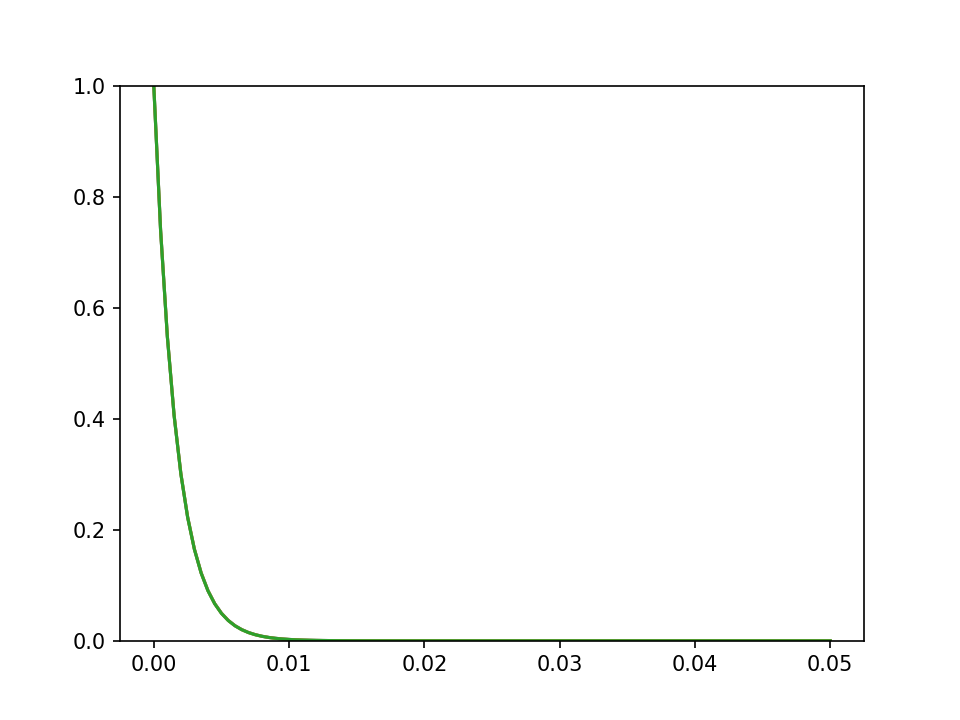

In [155]:
x_arr = np.linspace(0,0.05,101)
T_ = 600
a=1
b=600
plt.figure()
plt.plot(x_arr,np.exp(-x_arr*T_))
plt.plot(x_arr,x_arr**(a-1)*(1-x_arr)**(b-1))
plt.plot(x_arr,(1-x_arr)**(T_))
plt.ylim([0,1])
plt.show()